In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
date_columns = [
                'Account_Created_Date', 'Opportunity_Created_Date',
                'Quote_Expiry_Date', 'Last_Modified_Date',
                'Planned_Delivery_Start_Date','Planned_Delivery_End_Date',
                ]

categorical_columns = [
        'Region', 'Territory', 'Bureaucratic_Code',
        'Source ', 'Billing_Country', 'Account_Name',
        'Opportunity_Name', 'Account_Owner', 'Opportunity_Owner',
        'Account_Type', 'Opportunity_Type', 'Quote_Type',
        'Delivery_Terms', 'Brand', 'Product_Type',
        'Size', 'Product_Category_B', 'Currency',
        'Last_Modified_By', 'Product_Family', 'Product_Name',
        'ASP_Currency', 'ASP_(converted)_Currency', 'Delivery_Quarter',
        'Total_Amount_Currency', 'Total_Taxable_Amount_Currency', 'Stage',
        'Prod_Category_A'
    ]

# Columnnas excluidas porque tienen igual valor en todos sus registros
empty = ['Actual_Delivery_Date', 'Last_Activity',
        'Submitted_for_Approval','Prod_Category_A', 'Sales_Contract_No']

In [4]:

def open_and_filter(dataset):
    
    column_types = { col:'category' for col in categorical_columns }
    

    
    # read_csv
    df = pd.read_csv(dataset, parse_dates=date_columns, dtype=column_types,
                     index_col='ID', na_values=['Other', 'NaT', 'None'],
                     usecols=lambda x: x not in empty)


    # Re-typing
    df['Month'] = pd.to_datetime(df['Month'], format='%Y - %m')

    # Agruping regions (ME esta en EMEA)
    df.loc[((df.Region == "Middle East")), "Region"] = "EMEA"
    df.Region.cat.remove_categories('Middle East', inplace=True)

    df.Territory.cat.add_categories('Other', inplace=True)
    df.Territory.fillna('Other', inplace=True)
    # df.loc[(df.Territory == "None"), "Territory"] = "Other"
    df.loc[(df.Territory.str.contains("America")), "Region"] = "Americas"
    return df
    


# Pre-procesamiento de los datos

El objetivo de esta etapa, es recibir los datos "crudos" y realizar procedimientos necesarios para filtrar features de poco valor y crear otros features que revelen información de importancia, para que los modelos de machine learning que luego los utilizarán en una etapa posterior, puedan ralizar un predicción mas precisa.

# Fechas --> blocknumns

In [5]:
df1 = open_and_filter("rawdata/Train_TP2_Datos_2020-2C.csv")
df2 = open_and_filter("rawdata/Test_TP2_Datos_2020-2C.csv")

In [6]:
# df1.Total_Taxable_Amount_Currency.value_counts()

In [88]:
df1["Opportunity_Created_Date"].min()

Timestamp('2013-11-05 00:00:00')

Separo fecha en month y year (TODOS son en el primer dia del mes)

In [ ]:
FIRST_OPP = df1["Opportunity_Created_Date"].min()



def days_to(x):
    return (pd.to_datetime(x) - FIRST_OPP).days


#blocknum
df1['created_blocknum'] = df1["Opportunity_Created_Date"].apply(lambda x: days_to(x))
df2['created_blocknum'] = df2["Opportunity_Created_Date"].apply(lambda x: days_to(x))



df1['Month'] = pd.to_datetime(df1['Opportunity_Created_Date']).dt.month
df2['Month'] = pd.to_datetime(df2['Opportunity_Created_Date']).dt.month

df1['Month_Day'] = pd.to_datetime(df1['Opportunity_Created_Date']).dt.day
df2['Month_Day'] = pd.to_datetime(df2['Opportunity_Created_Date']).dt.day

df1['Week_Day'] = pd.to_datetime(df1['Opportunity_Created_Date']).dt.weekday
df2['Week_Day'] = pd.to_datetime(df2['Opportunity_Created_Date']).dt.weekday

In [8]:
pd.to_datetime(df2['Month']).dt.weekday

ID
6140     3
6146     3
6151     3
6118     3
6124     3
        ..
16345    3
15218    3
15224    3
7286     3
11263    3
Name: Month, Length: 2551, dtype: int64

In [9]:
print(f"The train set has {df1.shape[0]} elements and {df1.shape[1]} features")
print(f"The train set has {df2.shape[0]} elements and {df2.shape[1]} features")

The train set has 16947 elements and 49 features
The train set has 2551 elements and 48 features


# Features inteeresantes

Veces que aparece un opportunity_ID precios caantidades taxes etc

In [10]:
#ocurrencia
df1['Occur'] = df1['Opportunity_ID'].apply(lambda x: (df1['Opportunity_ID'] == x).sum())
df2['Occur'] = df2['Opportunity_ID'].apply(lambda x: (df2['Opportunity_ID'] == x).sum())


Dropeo stages != lost y won

In [11]:
valid_targets = ["Closed_Won", "Closen_Lost"]

df1.drop(df1[df1["Stage"].isin(valid_targets)].index, inplace=True)

Busco tiempo de entrega vs fecha de la opportunity
("demora dee la entrega", puede ser pactada)


In [12]:
#dlivery_blocknum
df1['early_delivery_blocknum'] = df1["Planned_Delivery_Start_Date"].apply(lambda x: days_to(x))
df2['early_delivery_blocknum'] = df2["Planned_Delivery_Start_Date"].apply(lambda x: days_to(x))
df1['early_delivery_blocknum'].describe()

count    16947.000000
mean      1379.671859
std        311.302756
min        787.000000
25%       1136.000000
50%       1392.000000
75%       1638.000000
max       2508.000000
Name: early_delivery_blocknum, dtype: float64

In [13]:
df1["delivery_delay"] = df1.apply(lambda x: x['early_delivery_blocknum']-x["created_blocknum"], axis=1)
df2["delivery_delay"] = df2.apply(lambda x: x['early_delivery_blocknum']-x["created_blocknum"], axis=1)
df1['delivery_delay'].describe()

count    16947.000000
mean        87.269782
std        107.792097
min       -286.000000
25%         14.000000
50%         52.000000
75%        117.000000
max       1812.000000
Name: delivery_delay, dtype: float64

Delivery Window

In [14]:
df1['late_delivery_blocknum'] = df1["Planned_Delivery_End_Date"].apply(lambda x: days_to(x))
df2['late_delivery_blocknum'] = df2["Planned_Delivery_End_Date"].apply(lambda x: days_to(x))


df1["delivery_window"] = df1.apply(lambda x: x['late_delivery_blocknum']-x["early_delivery_blocknum"], axis=1)
df2["delivery_window"] = df2.apply(lambda x: x['late_delivery_blocknum']-x["early_delivery_blocknum"], axis=1)
df1['delivery_window'].describe()

count    16872.000000
mean        22.957504
std        536.349394
min          0.000000
25%          0.000000
50%          4.000000
75%         25.000000
max      69474.000000
Name: delivery_window, dtype: float64

Last_Modified_Date hasta delivery

(Pensar si conviene qu esea modificado por una binaaria: modified_after_delivery_date / OJO POSIBLE LEAK)

In [15]:
df1['last_modified_blocknum'] = df1["Last_Modified_Date"].apply(lambda x: days_to(x))
df2['last_modified_blocknum'] = df2["Last_Modified_Date"].apply(lambda x: days_to(x))


df1["last_modified_to_delivery"] = df1.apply(lambda x: x['early_delivery_blocknum']-x["last_modified_blocknum"], axis=1)
df2["last_modified_to_delivery"] = df2.apply(lambda x: x['early_delivery_blocknum']-x["last_modified_blocknum"], axis=1)
df1['last_modified_to_delivery'].describe()

count    16947.000000
mean       -96.835251
std        149.571094
min      -1019.000000
25%       -201.000000
50%        -59.000000
75%          6.000000
max        689.000000
Name: last_modified_to_delivery, dtype: float64

Dias de creada hasta ul;tima modificacion (vida de la oportunidaad)

In [16]:
df1["opportunity_lifetime"] = df1.apply(lambda x: x['last_modified_blocknum']-x["created_blocknum"], axis=1)
df2["opportunity_lifetime"] = df2.apply(lambda x: x['last_modified_blocknum']-x["created_blocknum"], axis=1)
df1['opportunity_lifetime'].describe()


count    16947.000000
mean       184.105033
std        146.657257
min          0.000000
25%         65.000000
50%        162.000000
75%        282.000000
max       1775.000000
Name: opportunity_lifetime, dtype: float64

Dias desde la creacion de la cuentaa hasta lla creacion dela oportunidad (clientes viejos)


In [17]:
df1['account_creation_blocknum'] = df1["Account_Created_Date"].apply(lambda x: days_to(x))
df2['account_creation_blocknum'] = df2["Account_Created_Date"].apply(lambda x: days_to(x))

df1["account_creation_to_created_opp"] = df1.apply(lambda x: x['created_blocknum']-x["account_creation_blocknum"], axis=1)
df2["account_creation_to_created_opp"] = df2.apply(lambda x: x['created_blocknum']-x["account_creation_blocknum"], axis=1)
df1['account_creation_to_created_opp'].describe()


count    16947.000000
mean       702.680769
std        546.362513
min       -490.000000
25%        238.000000
50%        617.000000
75%       1131.000000
max       1980.000000
Name: account_creation_to_created_opp, dtype: float64

Vida del presupuesto (dias desde la creacion de la oportunidad al vencimiento del presupuesto)

In [18]:
df1['quote_blocknum'] = df1["Quote_Expiry_Date"].apply(lambda x: days_to(x))
df2['quote_blocknum'] = df2["Quote_Expiry_Date"].apply(lambda x: days_to(x))

df1["quote_life"] = df1.apply(lambda x: x['quote_blocknum']-x["created_blocknum"], axis=1)
df2["quote_life"] = df2.apply(lambda x: x['quote_blocknum']-x["created_blocknum"], axis=1)
df1['quote_life'].describe()

count    12322.000000
mean        47.066061
std         77.794835
min      -1040.000000
25%          7.000000
50%         27.000000
75%         57.000000
max       1798.000000
Name: quote_life, dtype: float64

Dias desde el fin del presupuesto hasta la ultima modificacion

Al parecer no aporta nada

In [19]:
df1["quote_to_last_modified"] = df1.apply(lambda x: x['last_modified_blocknum']-x["quote_blocknum"], axis=1)
df2["quote_to_last_modified"] = df2.apply(lambda x: x['last_modified_blocknum']-x["quote_blocknum"], axis=1)
df1['quote_to_last_modified'].describe()
df1.groupby('Stage')['quote_to_last_modified'].describe()

,count,mean,std,min,25%,50%,75%,max
Stage,,,,,,,,
Closed Lost,4234.0,132.017950,153.978444,-324.0,17.0,94.0,223.0,1247.0
Closed Won,8055.0,142.022222,138.816814,-220.0,13.0,120.0,247.0,1040.0
Negotiation,17.0,-96.705882,76.186256,-188.0,-188.0,-42.0,-22.0,-22.0
Proposal,15.0,-35.066667,64.521831,-146.0,-38.5,-22.0,-17.5,118.0
Qualification,1.0,-192.000000,NaN,-192.0,-192.0,-192.0,-192.0,-192.0


Dias desde el presupuesto hasta el late deliver

In [20]:
df1["quote_to_late_deliver"] = df1.apply(lambda x: x['late_delivery_blocknum']-x["quote_blocknum"], axis=1)
df2["quote_to_late_deliver"] = df2.apply(lambda x: x['late_delivery_blocknum']-x["quote_blocknum"], axis=1)
# df1['quote_to_late_deliver'].describe()
df1.groupby('Stage')['quote_to_late_deliver'].describe()

,count,mean,std,min,25%,50%,75%,max
Stage,,,,,,,,
Closed Lost,4220.0,112.297156,1073.242846,-319.0,21.0,62.0,137.0,69396.0
Closed Won,8013.0,20.095595,57.276801,-353.0,0.0,8.0,30.0,1157.0
Negotiation,17.0,29.176471,76.095528,-58.0,-21.0,58.0,59.0,255.0
Proposal,15.0,179.666667,179.014631,0.0,51.5,119.0,218.0,570.0
Qualification,1.0,0.000000,NaN,0.0,0.0,0.0,0.0,0.0


Conversion de precios


In [21]:
df1["currency_conversion_rate"] = df1.apply(lambda x: x["ASP_(converted)"]/x['ASP'] if x["ASP"] != 0.000000 else 0, axis=1)
df2["currency_conversion_rate"] = df2.apply(lambda x: x["ASP_(converted)"]/x['ASP'] if x["ASP"] != 0.000000 else 0, axis=1)
df1['currency_conversion_rate'].value_counts()

df1['converted_taxable_amount'] = df1.apply(lambda x: x['currency_conversion_rate']*x["Total_Taxable_Amount"], axis=1)
df2['converted_taxable_amount'] = df2.apply(lambda x: x['currency_conversion_rate']*x["Total_Taxable_Amount"], axis=1)

df1['converted_taxable_amount'].describe()

count    1.373800e+04
mean     2.434266e+06
std      1.575504e+07
min      0.000000e+00
25%      4.460273e+04
50%      1.440736e+05
75%      6.023119e+05
max      1.356339e+09
Name: converted_taxable_amount, dtype: float64

In [22]:
df1["Total_Taxable_Amount"].describe()

count    1.694700e+04
mean     3.224117e+06
std      2.030360e+07
min      0.000000e+00
25%      8.546580e+04
50%      3.760672e+05
75%      1.037450e+06
max      1.356339e+09
Name: Total_Taxable_Amount, dtype: float64

### Precios
Analisis de monedas y ver si estan repetidas

In [23]:
# df1['ASP_Currency'].value_counts()
# df1['Total_Amount_Currency'].value_counts()
# df1['Total_Taxable_Amount_Currency'].value_counts()
df1.groupby(['ASP_Currency','Total_Amount_Currency','Total_Taxable_Amount_Currency'])['Stage'].value_counts()
# print(df1.shape)
# # df1[((df1['ASP_Currency']==df1['Total_Amount_Currency'])&(df1['ASP_Currency']==df1['Total_Taxable_Amount_Currency']))].shape
# df1[((df1['ASP_Currency']==df1['Total_Amount_Currency'])&(df1['ASP_Currency']==df1['Total_Taxable_Amount_Currency']))].shape


# df2[((df2['ASP_Currency']==df2['Total_Amount_Currency'])&(df2['ASP_Currency']==df2['Total_Taxable_Amount_Currency']))].shape

ASP_Currency  Total_Amount_Currency  Total_Taxable_Amount_Currency  Stage        
AUD           AUD                    AUD                            Closed Won        406
                                                                    Closed Lost       147
                                     USD                            Closed Lost         2
                                                                    Closed Won          1
EUR           EUR                    EUR                            Closed Won       2422
                                                                    Closed Lost      2078
                                                                    Negotiation         1
                                                                    Proposal            1
                                     USD                            Closed Lost         1
GBP           GBP                    EUR                            Closed Lost         1
                  

### DISTRIBUCIONES

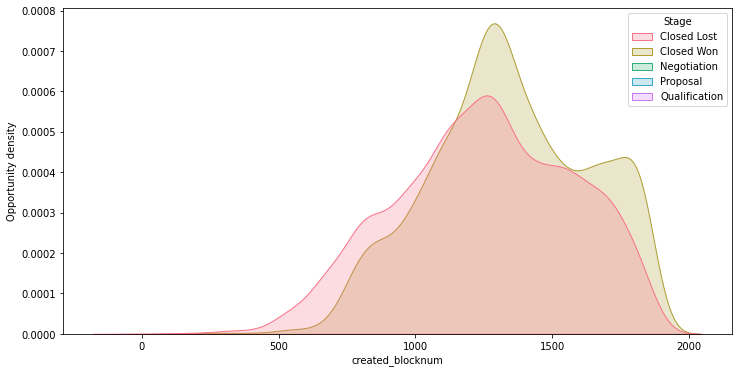

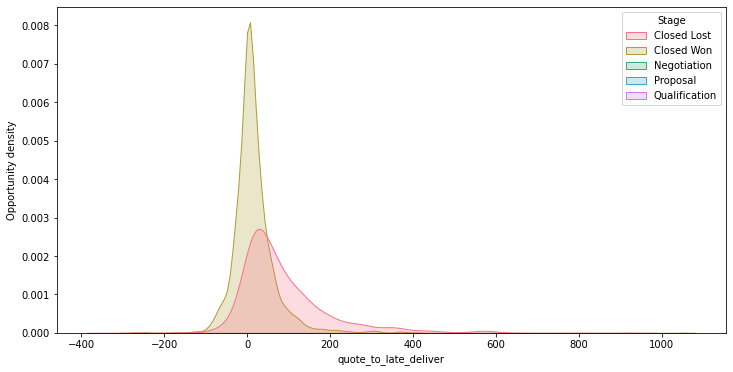

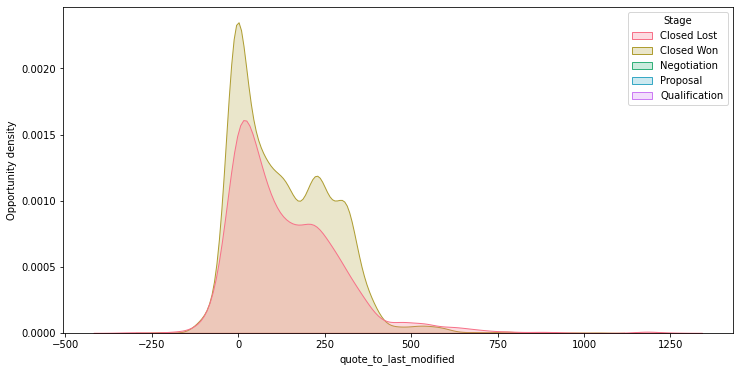

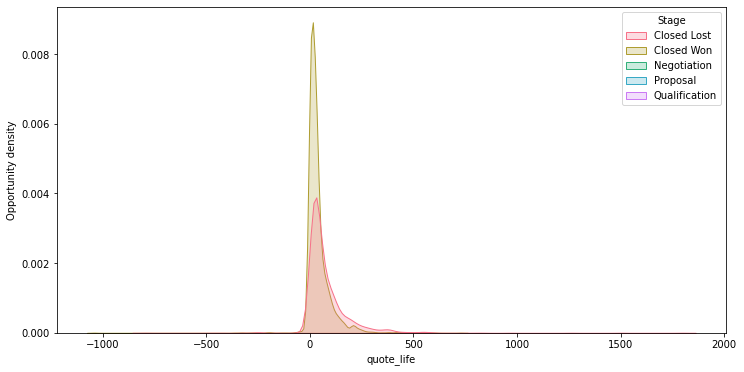

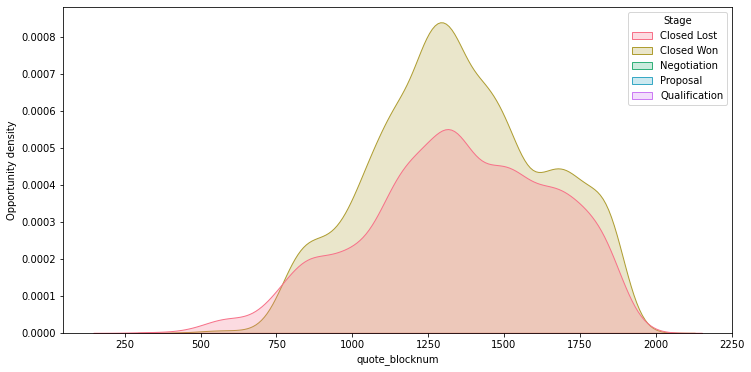

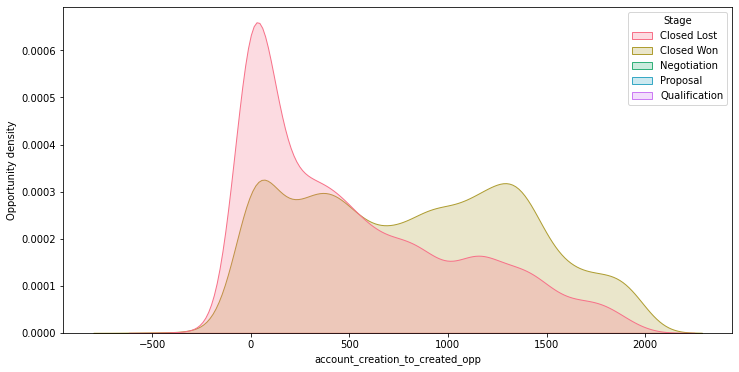

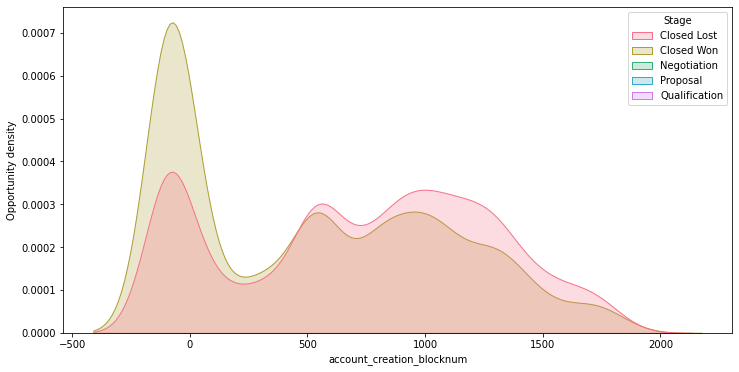

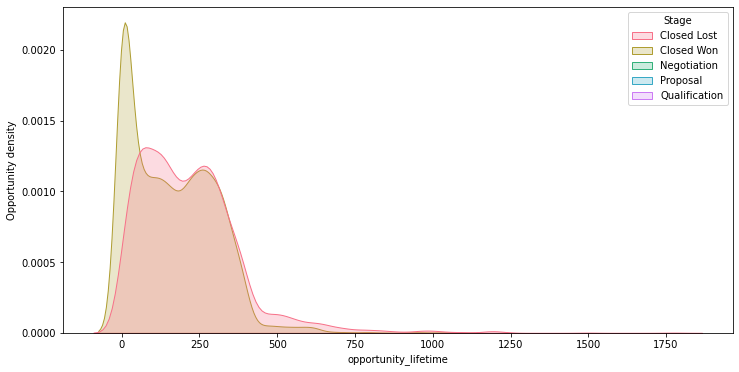

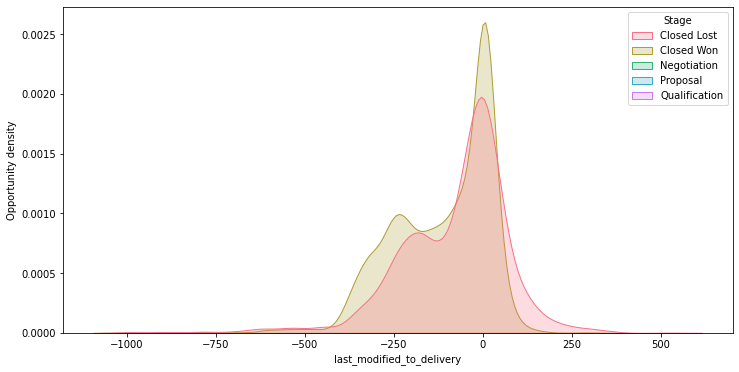

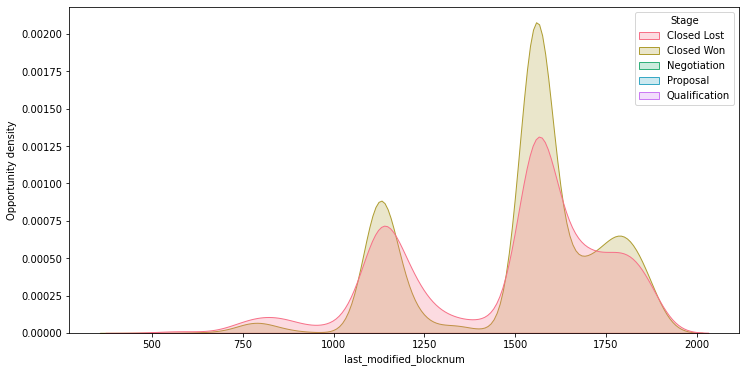

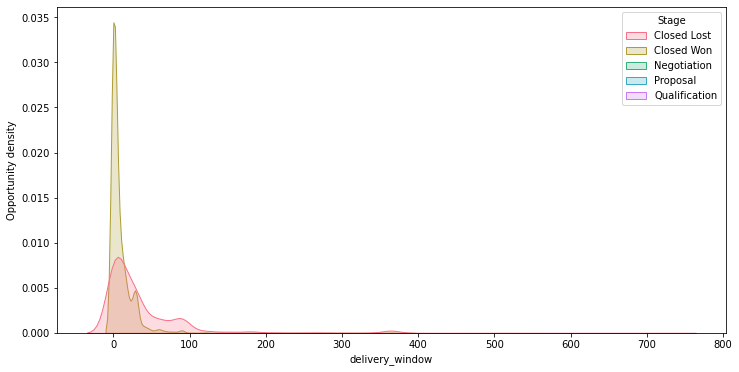

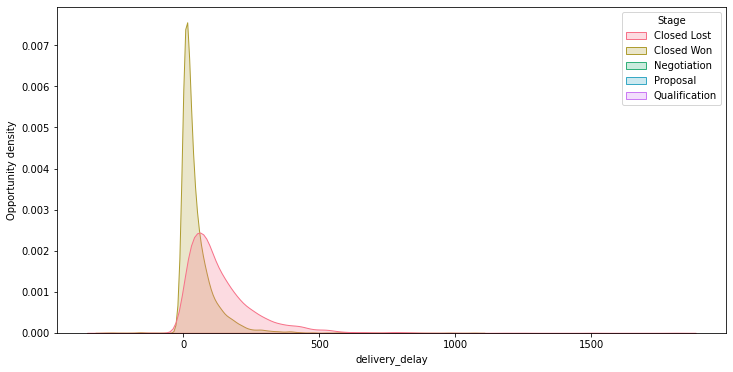

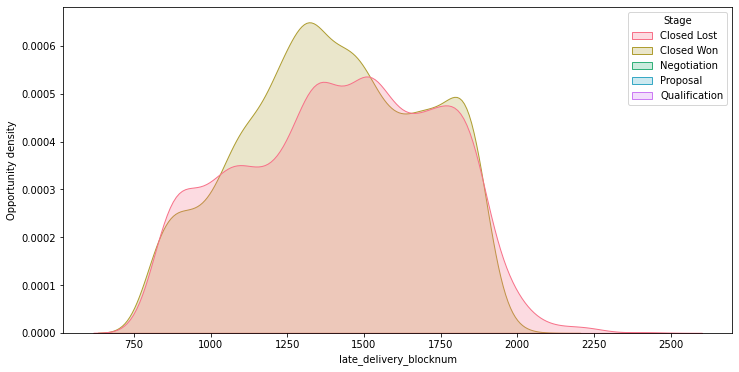

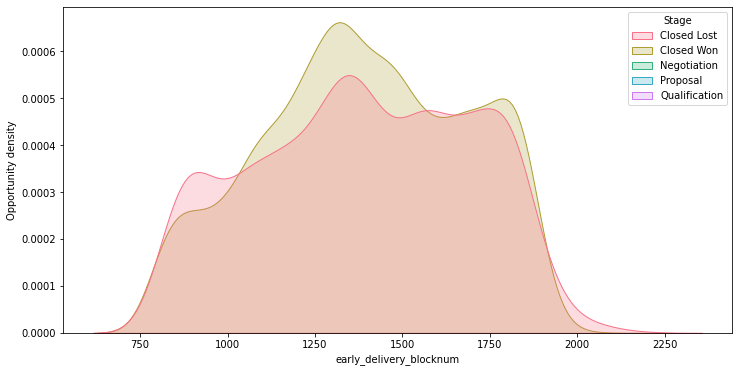

In [24]:
dt_columns = ['created_blocknum', "quote_to_late_deliver", "quote_to_last_modified", "quote_life", "quote_blocknum",
"account_creation_to_created_opp", "account_creation_blocknum", "opportunity_lifetime", "last_modified_to_delivery",
"last_modified_blocknum", "delivery_window", "delivery_delay", "late_delivery_blocknum", "early_delivery_blocknum"]
for dt in dt_columns:
    data = df1[(df1["Stage"]=="Closed Won") | (df1["Stage"]=="Closed Lost")].drop_duplicates(subset=['Opportunity_ID'], keep='last').reset_index()
    fig, ax = plt.subplots(figsize = (12,6))
    fig = sns.kdeplot(data=data, x=dt, hue="Stage", fill=True, ax=ax, palette="husl")
    fig.set_ylabel("Opportunity density")
    fig.set_xlabel(dt)
    fig.plot()


c:\users\fedeb\desktop\datos\workspace\venv\lib\site-packages\seaborn\distributions.py:1659: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.075 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
c:\users\fedeb\desktop\datos\workspace\venv\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


[]

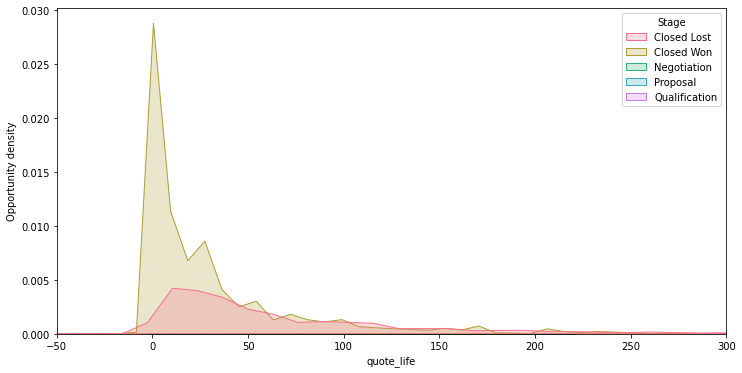

In [87]:
fig, ax = plt.subplots(figsize = (12,6))
fig = sns.kdeplot(data=df1, x='quote_life', hue="Stage", fill=True, ax=ax, palette="husl", bw=0.075)
fig.set_ylabel("Opportunity density")
fig.set_xlabel('quote_life')
fig.set_xlim(-50,300)
fig.plot()

# Columnas que descartan closed won

In [25]:
#TODOS LOS QUE TIENEN ESTAAS COLUMNAS SON LOST
for column in df1.columns:
    if np.sum(df1[df1['Stage']=='Closed Won'][column].value_counts())==0:
        print(column)
print("FIN...")


Brand
Product_Type
Size
Product_Category_B
Price
Currency
FIN...


In [26]:
lost_condition_df1 = (~df1['Brand'].isna() | ~df1['Product_Type'].isna() | ~df1['Size'].isna()\
                 | ~df1['Product_Category_B'].isna() | ~df1['Currency'].isna() | ~df1['Price'].isna())
lost_condition_df2 = (~df2['Brand'].isna() | ~df2['Product_Type'].isna() | ~df2['Size'].isna()\
                 | ~df2['Product_Category_B'].isna() | ~df2['Currency'].isna() | ~df2['Price'].isna())
lost_condition_df1.value_counts()

False    16023
True       924
dtype: int64

In [27]:
df1['lost'] = lost_condition_df1
df2['lost'] = lost_condition_df2




In [28]:
# Hypotesis: the features that contains more than 75% of NaN values 
#            do not contribute sustancial inforation


na_values_rate = df1.isna().sum()/len(df1)
na_values_rate = na_values_rate[na_values_rate>0]
na_values_rate

Source                       0.560394
Billing_Country              0.001593
Account_Type                 0.006609
Brand                        0.974686
Product_Type                 0.970673
Size                         0.965422
Product_Category_B           0.970732
Price                        0.978993
Currency                     0.947188
Quote_Expiry_Date            0.272910
ASP                          0.189355
ASP_(converted)              0.189355
Planned_Delivery_End_Date    0.004426
Total_Amount                 0.003481
late_delivery_blocknum       0.004426
delivery_window              0.004426
quote_blocknum               0.272910
quote_life                   0.272910
quote_to_last_modified       0.272910
quote_to_late_deliver        0.276214
currency_conversion_rate     0.189355
converted_taxable_amount     0.189355
dtype: float64

In [29]:
# Drop the most empty features
to_drop = na_values_rate[na_values_rate > 0.75].index.to_list()

trainset = df1.drop(columns = to_drop)
testset = df2.drop(columns= to_drop)

text = "', '".join(to_drop)
print(f"Columns '{text}' dropped")

Columns 'Brand', 'Product_Type', 'Size', 'Product_Category_B', 'Price', 'Currency' dropped


Para este modelo entonces se factorizan las columnas ``'Brand'``, ``'Product_Type'``, ``'Size'``, ``'Product_Category_B'``, ``'Price'``, ``'Currency'`` a una sola ``'lost'``

In [30]:
# The remaining features with na_values
contains_na = na_values_rate[na_values_rate <= 0.75].index.to_list()
na_values_rate[contains_na]

Source                       0.560394
Billing_Country              0.001593
Account_Type                 0.006609
Quote_Expiry_Date            0.272910
ASP                          0.189355
ASP_(converted)              0.189355
Planned_Delivery_End_Date    0.004426
Total_Amount                 0.003481
late_delivery_blocknum       0.004426
delivery_window              0.004426
quote_blocknum               0.272910
quote_life                   0.272910
quote_to_last_modified       0.272910
quote_to_late_deliver        0.276214
currency_conversion_rate     0.189355
converted_taxable_amount     0.189355
dtype: float64

In [31]:
def my_fill_na(df,columns):

    result = df.copy()
    dtypes = result[columns].dtypes
    cat = dtypes[dtypes == "category"].index.to_list()
    not_cat = dtypes[dtypes != "category"].index.to_list()
    
    for col in cat:
        if "Other" not in result[col].cat.categories:
            result[col].cat.add_categories("Other",inplace=True)
        result[col].fillna("Other",inplace= True)
    
    for col in not_cat:
        result[col].fillna(result[col].mean(),inplace= True)

    
    return result

In [32]:
trainset = my_fill_na(trainset,contains_na)
testset = my_fill_na(testset,contains_na)

In [33]:
na_train = trainset.isna().sum() > 0
na_test = testset.isna().sum() > 0

print(f"Restan valores nulos en trainset: {na_train.any()}")
print(f"Restan valores nulos en testset: {na_test.any()}")

Restan valores nulos en trainset: False
Restan valores nulos en testset: False


Ya filtramos las features con excesivos Nan values y rellenamos aquellas que su procentage de nan values es moderado, con valores predeterminados.

### Definición del target de los modelos

In [34]:
trainset["target"] = (trainset["Stage"] == "Closed Won").astype(int)
trainset[["Stage","target"]].head(10)


,Stage,target
ID,,
27761,Closed Lost,0
27760,Closed Won,1
27446,Closed Won,1
16808,Closed Lost,0
16805,Closed Lost,0
16802,Closed Lost,0
16799,Closed Lost,0
27455,Closed Won,1
24353,Closed Lost,0


### DISTRIBUCIONES

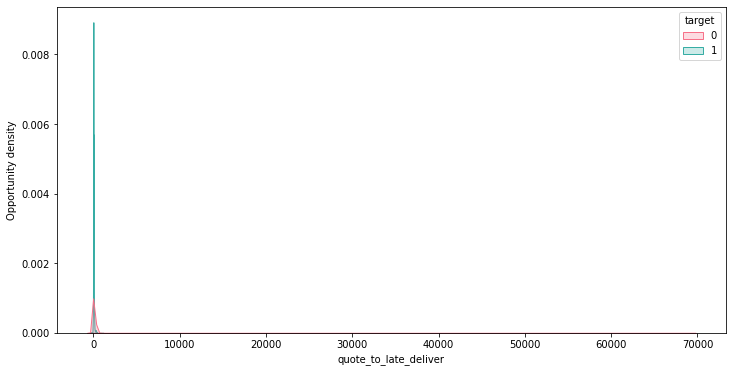

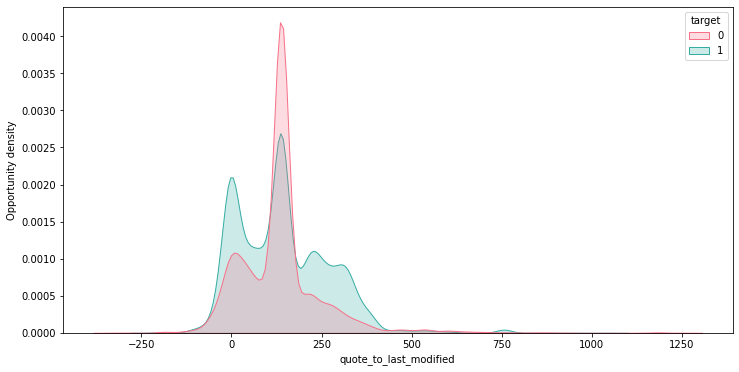

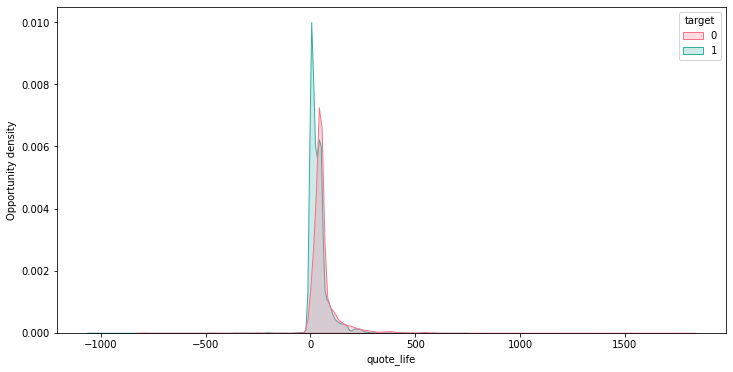

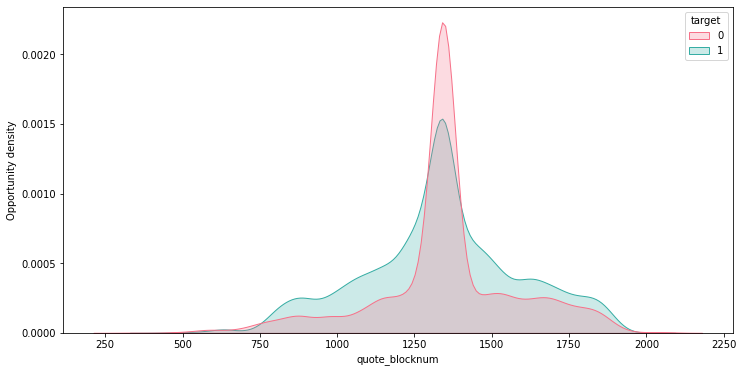

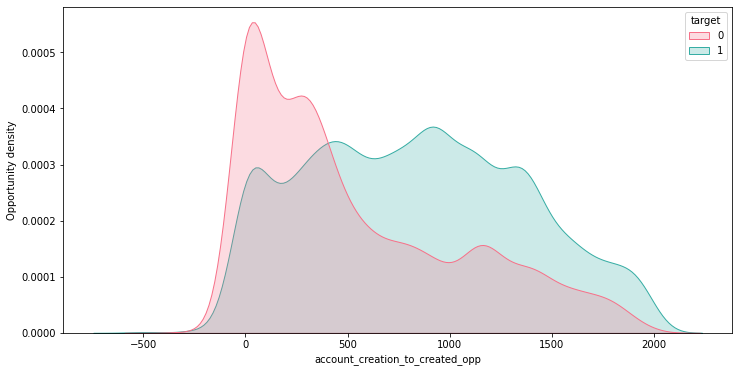

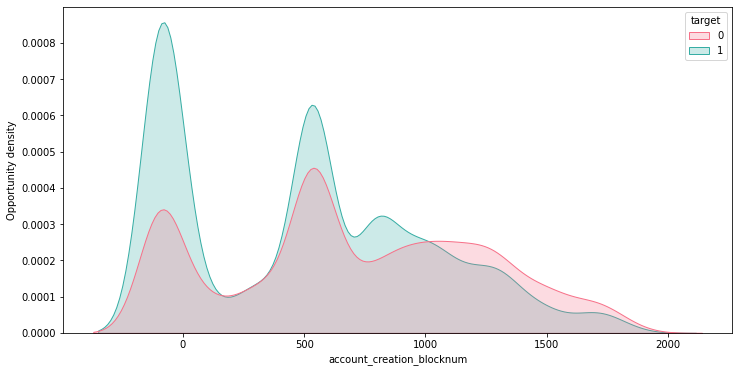

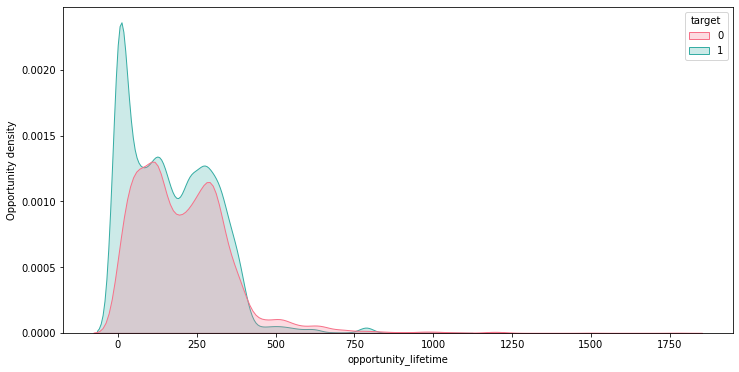

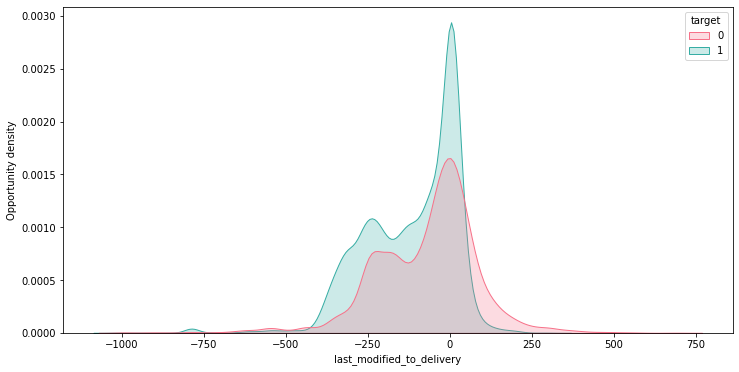

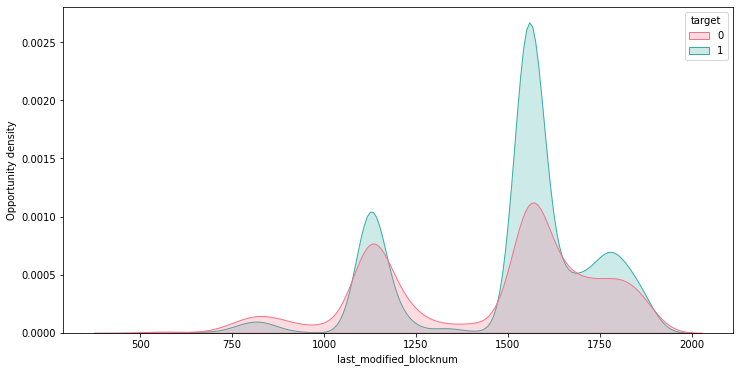

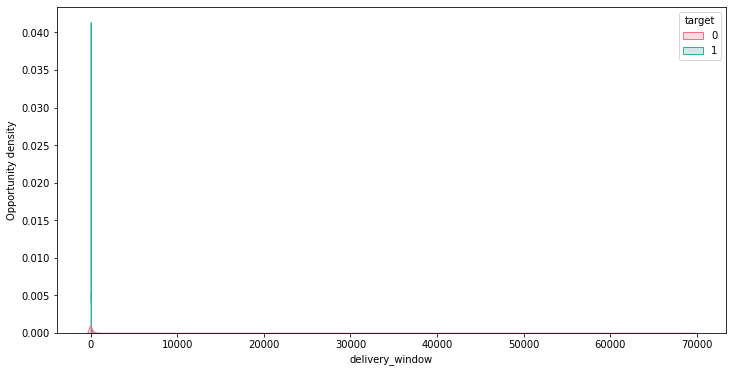

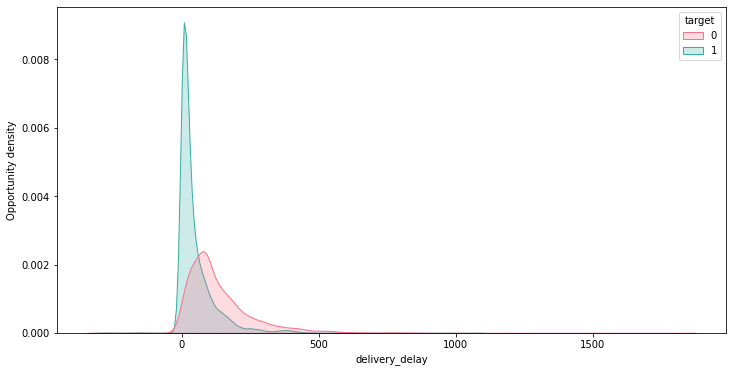

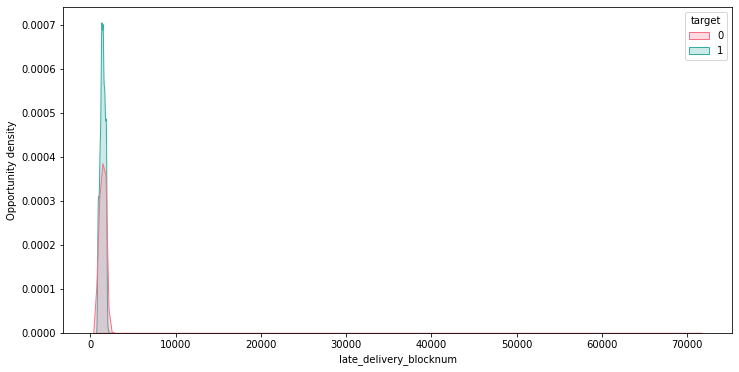

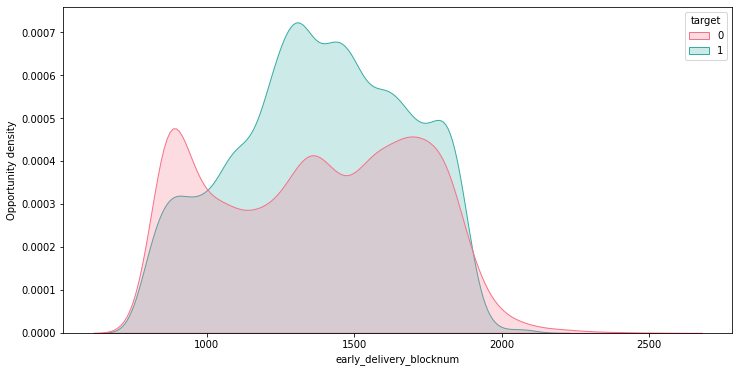

In [35]:
dt_columns = ["quote_to_late_deliver", "quote_to_last_modified", "quote_life", "quote_blocknum",
"account_creation_to_created_opp", "account_creation_blocknum", "opportunity_lifetime", "last_modified_to_delivery",
"last_modified_blocknum", "delivery_window", "delivery_delay", "late_delivery_blocknum", "early_delivery_blocknum"]
for dt in dt_columns:
    data = trainset
    fig, ax = plt.subplots(figsize = (12,6))
    fig = sns.kdeplot(data=data, x=dt, hue="target", fill=True, ax=ax, palette="husl")
    fig.set_ylabel("Opportunity density")
    fig.set_xlabel(dt)
    fig.plot()



### Definición de valores categóricos

En esta sección, lo que vamos a hacer es buscar valores categóricos de los features del set de datos de prueba que no hayan sido contemplados en el set de entrenamiento, que por lo consiguiente, el modelo de machine learning los va a desconocer.

Una vez identificados, los reemplazaremos con un valor genérico para "otros valores"

In [37]:
set_A = set(testset["Territory"].value_counts().index)
set_B = set(trainset["Territory"].value_counts().index)
for value in set_B: set_A.discard(value)
set_A

{'Andorra', 'Finland', 'Mongolia'}

In [38]:
official_values = trainset["Delivery_Quarter"].cat.categories.to_list()
test_values = testset["Delivery_Quarter"].cat.categories.to_list()
display(official_values)
display(test_values)

['Q1', 'Q2', 'Q3', 'Q4']

['Q1', 'Q2', 'Q3', 'Q4']

In [39]:
excluded = empty+to_drop+["Stage","Opportunity_Name"]
results = []
for column in categorical_columns:
    if column in excluded: continue
    
    official_values = trainset[column].cat.categories.to_list()
    test_values = testset[column].cat.categories.to_list()
    
    other_values = set(test_values)
    for value in official_values: other_values.discard(value)
    
    if len(other_values)>0:
        
        if not "Other" in testset[column].cat.categories.to_list():
            testset[column].cat.add_categories("Other",inplace=True)
        
        if not "Other" in trainset[column].cat.categories.to_list():
            trainset[column].cat.add_categories("Other",inplace=True)
            
        testset[column].replace({x:"Other" for x in other_values},inplace=True)
    
        results.append((column,len(other_values)))


In [40]:
others_df = pd.DataFrame(results,columns= ["column", "discarted values"])
others_df

,column,discarted values
0,Territory,3
1,Billing_Country,3
2,Account_Name,205
3,Opportunity_Owner,5
4,Last_Modified_By,8
5,Product_Family,20
6,Product_Name,50


In [41]:
display(round(others_df["discarted values"].describe(),2))
print(f"\nTotal test values discarted {others_df['discarted values'].sum()}, ",end="")
print(f"%{100*round(others_df['discarted values'].sum()/testset.size,3)} of total test data")

count      7.00
mean      42.00
std       73.81
min        3.00
25%        4.00
50%        8.00
75%       35.00
max      205.00
Name: discarted values, dtype: float64


Total test values discarted 294, %0.2 of total test data


La información descartada es muy poca con respecto al volumen del set. Más adelante veremos si es posible extraer información de esto

### One-hot encoding 
Realizaremos un dataset básico para poder correr el modelo por primera vez y observar los resultados.
Luego realizaremos mejoras e ingeniería de features para ver como se comporta el modelo.

In [42]:
from sklearn.preprocessing import OneHotEncoder 

In [43]:
print(f"El set de entrenamiento tiene {trainset.size} elementos")
print(f"El set de test tiene {testset.size} elementos")

El set de entrenamiento tiene 1033767 elementos
El set de test tiene 150509 elementos


In [44]:
excluded = empty+to_drop
excluded.append("Opportunity_Name")
excluded.append("Stage")
excluded.append("target")
toEncode = set([col if col not in excluded else "" for col in categorical_columns])
toEncode.discard("")

##remuevo por criterio de analissi de precio
toEncode.remove('Total_Amount_Currency')
toEncode.remove('Total_Taxable_Amount_Currency')
toEncode = list(toEncode)

print("Features categóricos a encodear")
toEncode

Features categóricos a encodear


['Delivery_Terms',
 'Opportunity_Owner',
 'Bureaucratic_Code',
 'Account_Type',
 'Territory',
 'Delivery_Quarter',
 'Source ',
 'ASP_(converted)_Currency',
 'Opportunity_Type',
 'Billing_Country',
 'Product_Family',
 'Quote_Type',
 'Last_Modified_By',
 'Product_Name',
 'Region',
 'Account_Name',
 'Account_Owner',
 'ASP_Currency']

In [45]:
enc = OneHotEncoder(drop='if_binary')
enc.fit(trainset[toEncode])
ohed = pd.DataFrame(enc.transform(trainset[toEncode]).toarray())
print(f"Shape: {ohed.shape}")
print(f"Size: {ohed.size}")
ohed.info()

Shape: (16947, 2707)
Size: 45875529
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16947 entries, 0 to 16946
Columns: 2707 entries, 0 to 2706
dtypes: float64(2707)
memory usage: 350.0 MB


Decidimos abandonar esta propuesta debido a la poca escalabilidad que tiene este método. Debido a las numerosas columnas categóricas con numerosos valores posibles cada una, necesitamos un total de ``2.723`` columnas para `16.947` entradas, lo cual nos deja un total de `46.146.681` valores en nuestra tabla.

### Binary encoding 

Este método nos permite encodear las features categóricas reduciendo considerablemente el dataset. Si suponemos que los 16.947 valores categóricos posibles se distribuyen uniformemente en las 7 columnas, entonces necesitaremos ``⌊log_2(16.947/7)⌋ + 1  = 9`` columnas nuevas por cada columna categórica original del dataset. En total ``9*7 = 63`` una propuesta cuestionable pero mucho mejor que la anterior. 

In [46]:
import math
class BinaryEncoding():
    
    def __init__(self):
        self.__encodings = {}
        
    def __make_encoding(self,name,categories):

        encoding = {}
        n_cols = int(math.log(len(categories),2))+1
        cols_names = [ name+"_"+str(x) for x in range(n_cols) ]

        for i in range(len(categories)):
            encoding[categories[i]] = list(f'{bin(i)[2:]}'.zfill(n_cols))

        return (encoding,cols_names)
    
    def encode_Series(self, serie, name,verbose=False):
        
        
        if not name in self.__encodings:

            categories = serie.cat.categories.to_list()
            self.__encodings[name] =  self.__make_encoding(name,categories)
        
        encoding,cols_names = self.__encodings[name]
        data = []
        indexs = []
        
        for index, value in serie.items():

            data.append(encoding[value])
            indexs.append(index)

        df_result = pd.DataFrame(data,columns=cols_names,index=indexs)
        return df_result,cols_names
    
    def getEncoding(self):
        return self.__encodings
    
    def encode_DataFrame(self, df, toEncode, verbose = False):

        full_encoded,columns = self.encode_Series(df[toEncode[0]],toEncode[0],verbose)
       
        for col in toEncode[1:]:
            
            encoding,col_names = self.encode_Series(df[col],col,verbose)
            full_encoded[col_names] = encoding

        if verbose: evaluate_encoding(df[toEncode],full_encoded)

        return full_encoded


In [47]:
"""
def encode_serie(serie,name):
    
    encoding = {}
    categories = serie.cat.categories.to_list()
    n_cols = int(math.log(len(categories),2))+1
    cols_names = [ name+"_"+str(x) for x in range(n_cols) ]

    for i in range(len(categories)):
        encoding[categories[i]] = list(f'{bin(i)[2:]}'.zfill(n_cols))
    
    data = []
    indexs = []
    
    for index, value in serie.items():
        data.append(encoding[value])
        indexs.append(index)
        
    df_result = pd.DataFrame(data,columns=cols_names,index=indexs)
    return df_result, cols_names
"""
[]+[]

[]

In [48]:
def evaluate_encoding(original,encoded):

    # Recuento de cada una de las combinaciones de 
    # la lista de features categóricos sin encodear
    count1 = original.value_counts().to_frame()[0].values

    # Recuento de cada una de las combinaciones de 
    # la lista de features categóricos ENCODEADOS
    count2 = encoded.value_counts().to_frame()[0].values

    # Comparación
    print("El encoding fue realizado correctamente: ", np.equal(count1,count2).all())

In [49]:
"""
def BinaryEncoding(df,toEncode,verbose = False):
    
    print("Shape prev",df[toEncode].shape)
    
    full_encoded,columns = encode_serie(df[toEncode[0]],toEncode[0])
    for col in toEncode[1:]:
        encoding,col_names = encode_serie(df[col],col)
        full_encoded[col_names] = encoding
        
    if verbose: evaluate_encoding(df[toEncode],full_encoded)
        
    return full_encoded
"""
[]+[]

[]

In [50]:
encoder = BinaryEncoding()
trainEncoded = encoder.encode_DataFrame(trainset,toEncode,verbose=True)
testEncoded = encoder.encode_DataFrame(testset,toEncode,verbose=True)

El encoding fue realizado correctamente:  True
El encoding fue realizado correctamente:  True


In [51]:
print(f"Train-encoded shape: {trainEncoded.shape}")
print(f"Train-encoded size: {trainEncoded.size}")
print("--------------------------------")
print(f"Test-encoded shape: {testEncoded.shape}")
print(f"Test-encoded size: {testEncoded.size}")

Train-encoded shape: (16947, 91)
Train-encoded size: 1542177
--------------------------------
Test-encoded shape: (2551, 91)
Test-encoded size: 232141


Pudimos encodear las columnas categóricas reduciendo notablemente el espacio. El cálculo de columnas utilizadas previo valía con la suposición de que todas las features tenían la misma cantidad de valores. Pero aún no cumpliendose, la diferencia de columnas es poca con respecto al resultado obtenido con One Hot Encoding

Terminamos este procesamiento de datos, para ver como un modelo de RandomForest se comporta frente a esto.

In [52]:
final_cols = list()
categorical_columns.append("target")
for col in trainset.columns.to_list():
    if not col in categorical_columns and not col in date_columns:
        final_cols.append(col)
print(f"Selected {len(final_cols)} features no categóricos")
final_cols

Selected 32 features no categóricos


['Pricing, Delivery_Terms_Quote_Appr',
 'Pricing, Delivery_Terms_Approved',
 'Bureaucratic_Code_0_Approval',
 'Bureaucratic_Code_0_Approved',
 'Opportunity_ID',
 'ASP',
 'ASP_(converted)',
 'Month',
 'Delivery_Year',
 'TRF',
 'Total_Amount',
 'Total_Taxable_Amount',
 'created_blocknum',
 'Month_Day',
 'Week_Day',
 'Occur',
 'early_delivery_blocknum',
 'delivery_delay',
 'late_delivery_blocknum',
 'delivery_window',
 'last_modified_blocknum',
 'last_modified_to_delivery',
 'opportunity_lifetime',
 'account_creation_blocknum',
 'account_creation_to_created_opp',
 'quote_blocknum',
 'quote_life',
 'quote_to_last_modified',
 'quote_to_late_deliver',
 'currency_conversion_rate',
 'converted_taxable_amount',
 'lost']

In [53]:
finalTrain = trainset.loc[:,final_cols+["target"]]
finalTrain[trainEncoded.columns.to_list()] = trainEncoded
finalTrain.shape

(16947, 124)

In [54]:
finalTest = testset.loc[:,final_cols]
finalTest[testEncoded.columns.to_list()] = testEncoded
finalTest.shape

(2551, 123)

In [55]:
# Se eliminaron las columnas vacías o con valores iguales
# Se rellenaron nan_values con promedios para features numéricos y con "others" para categóricos
# Se eliminaron valores categóricos del set de test que no estan en el set de entrenamiento
# Se realizó binary encoding para todos las features categóricas
# Se agregó la columna "target" la cual tiene 1/0 según es "Closed Won" o no
# Se eliminó la columna "Stage"

path = "datasets/"
name = "xgb"
finalTrain.to_csv(path+name+"-train.csv", index = False)
finalTest.to_csv(path+name+"-test.csv", index = False)